# Explore Spatial Label Propgation
### This notebook was used to explore the algorithm before the implementation in the soft-boiled code

In [ ]:
# Add to Spark context
sc.addPyFile('/local/path/to/soft-boiled.zip')

In [1]:
import collections
# local includes
from src.algorithms.algorithm import Algorithm
#from src.utils.geo import haversine, median_point
from src.utils.geo import median_point
from haversine import haversine
from src.utils.schema import get_twitter_schema
import numpy as np
import time

ImportError: No module named src.algorithms.algorithm

In [4]:
def get_at_mentions(inputRow):
    output = []
    if inputRow.user_mentions and len(inputRow.user_mentions) > 0:
        for user_mention in inputRow.user_mentions:
            src = inputRow.id_str
            dst = user_mention.id_str
            if src and dst:
                if src < dst:
                    canoncial = src + '_' + dst
                else:
                    canoncial = dst + '_' + src
                output.append((canoncial, (src, dst)))
    return output

In [5]:
def median_point2(points):
    """ Return the median point and the dispersion"""
    points_list = []
    for (point, isTrue) in points:
        if isTrue:
            return (point, isTrue)
        else:
            points_list.append(point)
    points = points_list
    if len(points) < 3:
        return None
    points = list(points)
    min_distance = None
    current_errors = None
    min_index = None
    for i in range(len(points)):
        distance_sum = 0
        errors = []
        for j in range(len(points)):
            error = haversine(points[j][1], points[j][0], points[i][1], points[i][0])
            errors.append(error)
        distance_sum = sum(errors)
        if min_distance is None or distance_sum < min_distance:
            min_distance = distance_sum
            current_errors = errors
            min_index = i
    if np.median(errors) > 100: # Enforce dispersion constraint
        return None
    return (points[min_index], False)

In [6]:
### Load some test data
may_tweets = sqlCtx.jsonFile('hdfs:///datasets/twitter/2015/*/*/*/*', get_twitter_schema('/local/path/to/format/twitter_format.json'))
may_tweets.registerTempTable('tweets')

## Build @Mention graph
### Graph is stored as an edge list

In [7]:
at_mention_graph = sqlCtx.sql('select user.id_str, entities.user_mentions from tweets where entities.user_mentions is not null')\
            .flatMap(get_at_mentions).groupByKey()\
            .filter(lambda (a,b): len(set(b)) > 1)\
            .flatMap(lambda (a,b): list(b)).coalesce(300)
at_mention_graph.cache()

CoalescedRDD[15] at coalesce at NativeMethodAccessorImpl.java:-2

In [6]:
at_mention_graph.flatMap(lambda (a,b): [a, b]).distinct().count()

4857805

In [8]:
user_locations_graph = sqlCtx.sql('select user.id_str, geo.coordinates from tweets where geo.coordinates is not null')\
            .map(lambda a: (a.id_str, a.coordinates))\
            .groupByKey().filter(lambda (a,b):len(b) > 3).mapValues(median_point).mapValues(lambda (a,b): a).coalesce(300)
user_locations_graph.cache()

CoalescedRDD[31] at coalesce at NativeMethodAccessorImpl.java:-2

In [9]:
print 'Total: ', user_locations_graph.count()
updatedLocations = user_locations_graph.filter(lambda (a,b): int(a[-1]) <=8)
testLocations = user_locations_graph.filter(lambda (a,b): int(a[-1]) > 8)
print 'Training Count:', updatedLocations.count()
print 'Test Count:', testLocations.count()
original_locations = updatedLocations

Total:  208888
Training Count: 190173
Test Count: 18715


In [10]:
# Filter edge list for known locations
filtered_edge_list = at_mention_graph.keyBy(lambda (a, b): b).leftOuterJoin(updatedLocations)\
.map(lambda (a, b): b).filter(lambda (a,b): b is None).map(lambda (a,b): a)
filtered_edge_list.cache()

PythonRDD[42] at RDD at PythonRDD.scala:42

In [39]:
# Get Unique users in filtered edge list
filtered_edge_list.flatMap(lambda (a,b): [a, b]).distinct().count()

4854029

In [24]:
updatedLocations = original_locations
num_partitions = updatedLocations.getNumPartitions()
print '# Partitions at start:', num_partitions

# Partitions at start: 300


In [18]:
local_edges = filtered_edge_list.collect()
known_locations = updatedLocations.collectAsMap()
test_locations = testLocations.collectAsMap()
local_edge_list = at_mention_graph.collect()

In [12]:
def median_point(points):
    """ Return the median point and the dispersion"""
    if len(points) < 3:
        return None
    points = list(points)[:20]
    min_distance = None
    current_errors = None
    min_index = None
    for i in range(len(points)):
        distance_sum = 0
        errors = []
        for j in range(len(points)):
            error = haversine(points[j][1], points[j][0], points[i][1], points[i][0])
            errors.append(error)
        distance_sum = sum(errors)
        if min_distance is None or distance_sum < min_distance:
            min_distance = distance_sum
            current_errors = errors
            min_index = i
    return (points[min_index], np.median(current_errors))

# This is the core SLP iteration

In [25]:
# Initial iteration
start_time = time.time()
for i in range(10):
    adjListWithLocations = filtered_edge_list.join(updatedLocations).map(lambda (a,b): (b[0], b[1])).groupByKey()
    new_locations = adjListWithLocations.map(lambda (a,b): (a, median_point(b))).filter(lambda (a,b): b is not None)\
        .filter(lambda (a,b): b[1] < 50).mapValues(lambda (a,b): a)
    updatedLocations = new_locations.union(original_locations).coalesce(num_partitions)
    
    found_locations_local =  testLocations.join(updatedLocations).collect()
    #print 'Number of Found Locations: ', len(found_locations_local)
    errors = []
    for (idstr, ll_tuple) in found_locations_local:
        (ll_1,ll_2) = ll_tuple
        errors.append(haversine(ll_1[1], ll_1[0], ll_2[1], ll_2[0]))
    #print np.median(errors), np.mean(errors)

    print i,updatedLocations.count(), len(found_locations_local), np.median(errors), time.time() - start_time

0 260277 781 12.7294206619 31.0848679543
1 351325 1341 17.8613262177 64.5007450581
2 439986 1708 22.2233352661 102.264163971
3 517457 1890 27.7568807602 141.208543062
4 581527 2036 31.3105392456 184.111522913
5 634709 2108 35.499162674 227.784286976
6 681382 2183 38.8336486816 272.32160902
7 718839 2218 40.9449272156 318.781810999
8 748300 2230 40.0671100616 365.979155064
9 770405 2257 43.4148406982 413.285179853


## Score Results

In [19]:
# How many test locations did we find
found_locations = testLocations.join(updatedLocations)
found_locations_local = found_locations.collect()
print 'Number of Found Locations: ', len(found_locations_local)
errors = []
for (idstr, ll_tuple) in found_locations_local:
    (ll_1,ll_2) = ll_tuple
    #print ll_1, ll_2
    errors.append(haversine(ll_1[1], ll_1[0], ll_2[1], ll_2[0]))
print np.median(errors), np.mean(errors)

Number of Found Locations:  2044
33.1009235382 966.627452076


In [28]:
errors_sorted = sorted(errors)
print np.median(errors_sorted), np.mean(errors_sorted)

 43.4148406982 1031.62009013


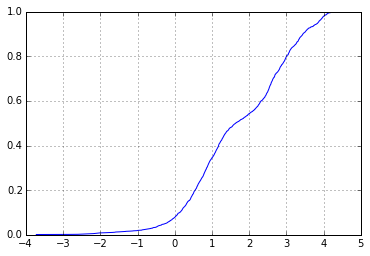

In [46]:
num_errors = len(errors_sorted)
from math import floor
divisors = []
for i in range(num_errors):
    divisors.append(i/float(num_errors))
plt.plot(np.log10(errors_sorted), divisors)
plt.grid(True)

In [ ]:
print errors_sorted[-1]

{'boxes': [<matplotlib.lines.Line2D at 0x7f19a006b1d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f19994ad190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f19994b7490>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f19994ade10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f19a006b450>,
  <matplotlib.lines.Line2D at 0x7f19a006bb10>]}

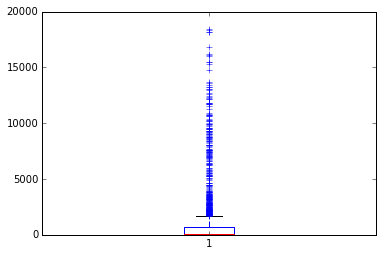

In [26]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.boxplot(errors)

# Local calculation

In [33]:
import collections
import time
from multiprocessing import Pool

def get_median_with_threshold(input_tuple):
    (usr_id, locations) = input_tuple
    (median_location, dispersion) = median_point(locations)
    if dispersion < 100:
        return (usr_id, median_location)
    else:
        return (usr_id, None)

def perform_slp(at_mention_graph, original_locations, test_locations, gamma):
    #known_locations = original_locations.copy()
    
    known_locations = {}
    start_time = time.time()
    print 'Building Filtered Edgelist', start_time
    # Build filtered edgelist
    filtered_edge_list = []
    for (src, dst) in at_mention_graph:
        if dst not in original_locations:
            filtered_edge_list.append((src, dst))
    NUM_ITERS = 4
    for i in range(NUM_ITERS):
        print 'Sending Known Locations', time.time() - start_time
        # Send known locations to destinations
        dst_locations = collections.defaultdict(list)
        for (src, dst) in filtered_edge_list:
            if src in known_locations:
                # If the src has a known location send it to the destination
                dst_locations[dst].append(known_locations[src])
            elif src in original_locations:
                dst_locations[dst].append(original_locations[src])
        
        print 'Calculating new known locations', time.time() - start_time
        # Single threaded implementation
        for dst in dst_locations:  
            locations = dst_locations[dst]
            if len(locations) > 3:
                (median_location, dispersion) = median_point(locations)
                if dispersion < gamma:
                    known_locations[dst] = median_location
        
        # Multi-Threaded but slower implementation
#         p = Pool(8)
#         locations_to_calculate = []
#         for dst in dst_locations:
#             locations = dst_locations[dst]
#             if len(locations) > 3:
#                 locations_to_calculate.append((dst, locations))
#             resulting_locations = p.map(get_median_with_threshold, locations_to_calculate)
#             known_locations = {}
#             for (usr_id, location) in resulting_locations:
#                 if location is not None:
#                     known_locations[usr_id] = location
        
        print i, len(known_locations), time.time() - start_time
    
    errors = []
    for usr_id, location in test_locations:
        if usr_id in known_locations:
            ll_1 = known_locations[usr_id]
            ll_2 = test_locations[usr_id]
            errors.append(haversine(ll_1[1], ll_1[0], ll_2[1], ll_2[0]))
    print len(errors), np.median(errors), np.mean(errors) 

In [ ]:
#local_edges
#known_locations
#test_locations
perform_slp(local_edge_list, known_locations, test_locations, 100)

In [20]:
len(known_locations)

190173